# Install dependencies

In [1]:
%pip install torch gensim datasets nltk

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.66.6-py3-none-any.whl.metadata (57 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached tqdm-4.66.6-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.2
    Uninstalling tqdm-4.65.2:
      Successfully uninstalled tqdm-4.65.2
  Attempting uninstall: requests
    Found existing installation: requests 2.28.2
    Uninstalling requests-2.28.2:
      Successfully uninstalled requests-2.28.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.1.2 requires requests~=2.28.2, but you have requests 2.32.3 which is incompatible.
openxlab 0.1.2 requires tqdm~=4.65.0, but you have tqdm 4.66.6 which is incompatible.


# Import dependencies


In [3]:
import os
import nltk
import json

nltk.download("all")


import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from datasets import load_dataset
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from gensim.downloader import load as load_word2vec

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_

# Part 0. Dataset Preparation


In [5]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simple statatistics about dataset


In [7]:
print(f"Size of training set: {train_dataset.num_rows} sentences")
print(f"Size of validation set: {validation_dataset.num_rows} sentences")
print(f"Size of test set: {test_dataset.num_rows} sentences")

Size of training set: 8530 sentences
Size of validation set: 1066 sentences
Size of test set: 1066 sentences


In [8]:
print(f"Sample sentence from train dataset: {test_dataset[0]['text']}")
print(f"Label: {'Positive' if test_dataset[0]['label'] == 1 else 'Negative'}")

Sample sentence from train dataset: lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .
Label: Positive


# Part 1. Preparing Word Embeddings


## Question 1. Word Embedding


#### `(a)` What is the size of the vocabulary formed from your training data?


In [9]:
# Tokenize each sentence
tokenized_texts = [word_tokenize(text["text"].lower()) for text in train_dataset]
print(f"Sample tokens from a sentence {tokenized_texts[0]}")

# Flatten all tokens in each token
all_tokens = [token for sentence in tokenized_texts for token in sentence]

# Create a Counter object to count the frequency of each token
vocab = {"<PAD>": 0, "<UNK>": 1}
for token in all_tokens:
    if token not in vocab:
        vocab[token] = len(vocab)

vocab_size = len(vocab)

print(f"Number of tokens in all sentences: {len(all_tokens)}")
print(f"Size of the vocabulary including PADDING and UNKNOWN tokens: {vocab_size}")
print(f"Size of the vocabulary: {vocab_size - 2}")

Sample tokens from a sentence ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', '``', 'conan', '``', 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'or', 'steven', 'segal', '.']
Number of tokens in all sentences: 183968
Size of the vocabulary including PADDING and UNKNOWN tokens: 18031
Size of the vocabulary: 18029


`<PAD>` token was introduced for easier processing at later steps. Because RNN requires all sentences having the same length

`<UNK>` token was introduced for handling unknown word in `Word2vec` vocabulary. All unkown words will be assigned as a `<UNK>` token

By using punkt tokenizer from NLTK, size of the vocabulary formed from training data is `18029`


#### `(b)` We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

#### `(c)` The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.


In [10]:
word2vec_path = f"{os.getcwd()}/word2vec.kv"
if os.path.isfile(word2vec_path):
    word2vec = KeyedVectors.load("./word2vec.kv")
else:
    word2vec = load_word2vec('word2vec-google-news-300')
    word2vec.save("word2vec.kv")

embedding_dim = word2vec.vector_size
print(f"Embedding dimensions: {embedding_dim}")

Embedding dimensions: 300


In [11]:
mean = np.mean(word2vec.vectors, axis=0)
std = np.std(word2vec.vectors, axis=0)

In [12]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_count = 0

# Step 3: Populate the embedding matrix
for word, index in vocab.items():
    if word in word2vec:
        embedding_matrix[index] = word2vec[word]
    else:
        # Handle OOV words with random initialization
        oov_count += 1
        embedding_matrix[index] = np.random.normal(
            loc=mean, scale=std, size=(embedding_dim,)
        )

print(f"Sample embeddings of {word}: {embedding_matrix[index]}")

Sample embeddings of portent: [ 2.30468750e-01 -1.02539062e-02  1.08886719e-01 -2.01171875e-01
  5.32226562e-02 -2.91748047e-02  4.68750000e-02  3.47900391e-03
  1.88476562e-01  3.94531250e-01 -8.36181641e-03 -2.08984375e-01
 -6.39648438e-02 -6.39648438e-02  6.62231445e-03  3.30078125e-01
  1.00585938e-01  3.10546875e-01  1.71875000e-01 -4.78515625e-01
  2.46047974e-04  9.81445312e-02  2.28515625e-01 -2.81250000e-01
  6.98242188e-02 -6.29882812e-02  1.91406250e-01  1.34765625e-01
  4.32128906e-02  5.03906250e-01 -2.09960938e-02 -1.01074219e-01
  2.69775391e-02  8.83789062e-02 -1.78710938e-01  6.15234375e-02
  7.37304688e-02 -4.37011719e-02  3.51562500e-02  5.29785156e-02
  4.92187500e-01  7.91015625e-02  9.66796875e-02  6.80541992e-03
 -1.01562500e-01  1.56250000e-01 -1.59179688e-01  2.04101562e-01
  2.02148438e-01 -1.04980469e-01  1.04980469e-01  1.71875000e-01
 -1.09863281e-01  1.14257812e-01 -1.37695312e-01  1.69921875e-01
 -8.01086426e-04 -1.74804688e-01  2.71484375e-01 -8.42285156

In [13]:
print(f"Number of out-of-vocabulary words: {oov_count - 2}")

Number of out-of-vocabulary words: 3612


`(b)` There are 3612 out-of-vocabulary words in our data


In [14]:
print(f"Sample embeddings of an unkown word: {embedding_matrix[vocab.get('<UNK>')]}")

Sample embeddings of an unkown word: [-0.10845984 -0.16204528  0.23937693  0.33402966 -0.16166752  0.34688544
  0.08347335 -0.20869506  0.15760394  0.07398049  0.08964366  0.39148335
 -0.11438953 -0.1806138  -0.11298459  0.02960817 -0.19154886  0.01971988
 -0.07196895 -0.01562685  0.1214673   0.06180076  0.09879548  0.17291716
 -0.13066365 -0.19286552 -0.071144   -0.26369853  0.02451819 -0.18994002
 -0.03021094  0.00242516 -0.02199215  0.02099018 -0.22804382 -0.1024296
  0.05896699  0.07867972 -0.22685327 -0.02681281 -0.07470651  0.13485781
  0.17622065  0.04720843  0.18114157 -0.32215128 -0.35220164  0.08052399
  0.14650248  0.11645477 -0.33708684  0.01517904  0.19468407  0.23339683
 -0.13642324 -0.02144729 -0.17753878 -0.10027646 -0.00235972 -0.09913028
 -0.08199009 -0.12132088 -0.08382822  0.08425414 -0.04398698  0.13039938
 -0.22402964 -0.16104669  0.12813888 -0.06737104  0.27753803 -0.13117966
 -0.03343794 -0.00435778  0.01932811 -0.05389595 -0.08678744 -0.14132741
 -0.14067685 -0

`(c)` To address out-of-vocabulary (OOV) words in Word2Vec, we assigned them embeddings generated from random samples of a normal distribution based on the mean and standard deviation of all existing word vectors. This approach offers several advantages:

- Consistency in Input: Randomly generated embeddings ensure a consistent shape and dimensionality for OOV words, facilitating seamless integration into the model.
- Statistical Alignment: By matching the mean and standard deviation of known embeddings, we align the OOV representations with the learned vocabulary, reducing the potential instability introduced by random noise.


# Part 2. Model Training & Evaluation - RNN


In [17]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        token_indices = self.__tokenizer(text, self.max_len)
        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(
            label, dtype=torch.long
        )

    def __tokenizer(self, sentence, max_len):
        tokens = word_tokenize(sentence.lower())
        token_indices = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
        token_indices = token_indices[:max_len]
        padded_tokens = token_indices + [vocab["<PAD>"]] * (
            max_len - len(token_indices)
        )
        return padded_tokens

In [19]:
class RNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, freeze_embeddings, pooling):
        super(RNNModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=freeze_embeddings,  # Freeze or unfreeze embeddings
        )

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.pooling = pooling  # 'max', 'average', or 'last'

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_output, hidden = self.rnn(embedded)

        if self.pooling == 'mask_max':
            # Max pooling over the RNN outputs
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            rnn_output = rnn_output.masked_fill(~mask, float('-inf'))
            pooled, _ = torch.max(rnn_output, dim=1)
        elif self.pooling == 'mask_average':
            # Average pooling over the RNN outputs
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            rnn_output = rnn_output * mask
            summed = rnn_output.sum(dim=1)
            valid_counts = mask.sum(dim=1)
            valid_counts = valid_counts.clamp(min=1)
            pooled = summed / valid_counts
        elif self.pooling == 'last':
            # Use the last hidden state
            pooled = hidden.squeeze(0)
        else:
            raise ValueError("Invalid pooling type. Choose from 'max', 'average', 'last'.")

        output = self.batch_norm(pooled)
        output = self.dropout(output)
        output = self.fc(output)

        return output

In [20]:
max_length = max(len(item) for item in tokenized_texts)
train_data = TextDataset(
    [item["text"] for item in train_dataset],
    [item["label"] for item in train_dataset],
    max_length,
)

valid_data = TextDataset(
    [item["text"] for item in validation_dataset],
    [item["label"] for item in validation_dataset],
    max_length,
)

test_data = TextDataset(
    [item["text"] for item in test_dataset],
    [item["label"] for item in test_dataset],
    max_length,
)

In [21]:
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    
    for texts, labels in data_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1
        )  # Apply gradient clipping to prevent exploding gradients
        optimizer.step()

        total_train_loss += loss.item()
        total_correct_train += (outputs.argmax(1) == labels).sum().item()
    train_loss = total_train_loss / len(data_loader)
    train_acc = total_correct_train / len(data_loader.dataset)
    return train_loss, train_acc


def evaluate_epoch(model, data_loader, criterion):
    model.eval()
    total_loss_val = 0
    total_correct_val = 0

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss_val += loss.item()
            total_correct_val += (outputs.argmax(1) == labels).sum().item()
    val_loss = total_loss_val / len(data_loader)
    val_acc = total_correct_val / len(data_loader.dataset)
    return val_loss, val_acc

def draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, title):
    num_epochs = len(train_losses)  # Number of epochs
    # Plotting train and validation loss
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label=f'Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label=f'Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label=f'Train Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label=f'Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

In [22]:

with open(f"{os.getcwd()}/best_config.json", "r") as file:
    best_params = json.load(file)
    # Hyperparameters
batch_size = best_params["batch_size"]
hidden_dim = best_params["hidden_dim"]
learning_rate = best_params["learning_rate"]
pooling = best_params["pooling"]
output_dim = 2
weight_decay = 1e-5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Part 3.5

### Attention RNN

Epoch [1/50]
Train Loss: 0.5468, Train Acc: 0.7028, Val Loss: 0.4640, Val Acc: 0.7730
Epoch [2/50]
Train Loss: 0.3007, Train Acc: 0.8727, Val Loss: 0.4975, Val Acc: 0.7852
Epoch [3/50]
Train Loss: 0.1321, Train Acc: 0.9503, Val Loss: 0.6142, Val Acc: 0.7805
Epoch [4/50]
Train Loss: 0.0486, Train Acc: 0.9830, Val Loss: 0.8321, Val Acc: 0.7852
Early stopping as validation accuracy is not improving


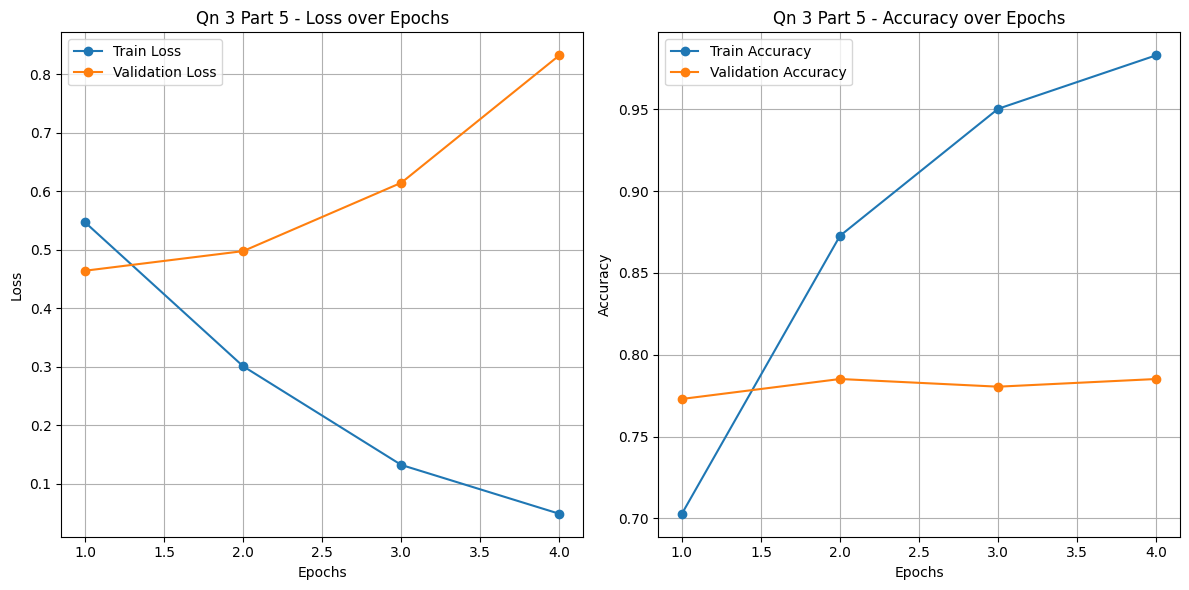

In [51]:
# Model stepup
import torch.nn.functional as F

## Attention RNN Model
class AttentionRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout_prob=0.2,freeze_embeddings=False):
        super(AttentionRNNModel, self).__init__()
        embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=vocab.get("<PAD>"),
            freeze=freeze_embeddings,
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        '''
        Attention - RNN architecture with Positional Encoding:
        x: words
        e: embeddings
        h: encoder output (encoder(e))
        s: decoder ouput (decoder(h))
        a: attention output
        '''
        
        # Embedding layer ([e1,e2,...,en])
        embedded = self.embedding(x)

        # RNN layer with dropout ([h1,h2,...,hn] RNN(xn x en))
        rnn_out, _ = self.rnn(embedded)
        rnn_out = self.dropout(rnn_out)
        
        # Attention mechanism ([a1,a2,...,an] an = softmax(sn x hn))
        attn_weights = F.softmax(self.attention(rnn_out), dim=1)
        
        # Weighted sum over softmaxes (sum(softmax(sn x hn) x hn))
        attn_output = torch.sum(attn_weights * rnn_out, dim=1)

        # Fully connected layer
        output = self.fc(attn_output)  # shape: [batch_size, output_dim]
        
        return output

# Initialize and train the model with an attention layer
model = AttentionRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()
model.to(device)


# Training the model with early stopping
num_epochs = 50
patience = 3
best_val_loss = float("inf")
early_stopping_count = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping if validation accuracy does not improve for 3 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Final - P3_Q5 - Word2vecAttention.pth')
        early_stopping_count = 0
    else:
        early_stopping_count += 1
        if early_stopping_count >= patience:
            print("Early stopping as validation accuracy is not improving")
            break

draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, "Qn 3 Part 5")

### Evaluate Performances

In [52]:

model = AttentionRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)
model.load_state_dict(torch.load('Final - P3_Q5 - Word2vecAttention.pth'))
model.to(device)
test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)

print(f'Attention + RNN Results - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Attention + RNN Results - Test Loss: 0.4211, Test Acc: 0.8227
